# Machine learning from scratch: Evaluation

## Introduction

In this notebook we will explore some common methods for evaluation and validation for our machine learning algorithms. The idea is not only to address the convergence of the algorithms to models that can reproduce the training data with very high accuracy, but also to estimate the predicting power of the model for yet unobserved data. For this we will introduce two numerical measures which we will call the **training error** and the **test error**. We will make use of the ideas of bias and variance discussed in [this](https://github.com/felperez/ML-miscellanea/blob/master/Bias%20vs%20variance.ipynb) notebook.

We will introduce several methods to assess how our models generalize to unseen data, and we will apply each of them to a dataset. In this notebook we will use a very basic dataset for a regression problem. In future notebooks we will explore in depth alternative measures for classification problems. Nonetheless, all the methods studied in this notebook also apply for classification problems, as they rely in the study of costs functions, which are also essential for most of classification problems.

The first three methods are called non-exhaustive methods, while the next three are called exhaustive, as they go through all the possible ways to split the dataset. This eliminates the randomness of the process, in a way to try reducing the splitting noise. Exhaustive methods tend to be more computationally expensive, so the non-exhaustive methods are a much cheaper alternative for very complex models, or models trained with large amounts of data.

## Dataset and regression

As mentioned in the introduction, we will use a regression problem as the main example for the methods that we will introduce in this notebook. We will generate a dataset which follows a linear trend plus some random noise, and then we will fit a linear model to it. Most of the ideas are extracted from [this](https://github.com/felperez/machine-learning/blob/master/1.%20Linear%20regression.ipynb) previous notebook. Let us generate some data

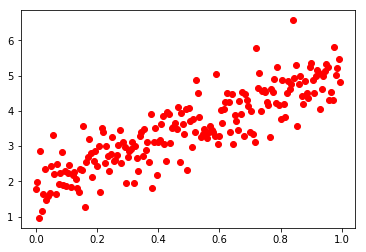

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#We fix the random seed for reproducibility of the results
np.random.seed(2)

#set the number of observations
num_obs = 200

#We generate random data that follows approximately a straight line with
#known parameters and known fluctuations
X = np.arange(0,1,1/num_obs)
y = 3*X + 2

#Now we add the random fluctuations
noise = np.random.normal(0,0.5,num_obs)
y = y + noise

#Now we plot the data
plt.plot(X,y,'ro')
plt.show()

Now we import a script with the linear regression class.


In [3]:
%run linear.py

The class linear_regression does not require any parameter at initialization, and it has the following methods:
+ *train(X_train,y_train,n,l)*, where X_train and y_train are the training data, n is the number of steps and l the learning rate.
+ *get_parameters()*, returns the parameters of the regression
+ *get_scores(X,y)*, returns the cost function computed with the dataset (X,y) and the parameters of the trained model
+ *get_cost_history(X,y)*, the algorithm stores the values of the parameters after every iteration, so this method returns the cost function computed with the dataset (X,y) and each of the parameters stored during the training process.
+ *predict(x)*, returns the predicted value of y for the point x, based on the parameters obtained by training the model.
We stress that this script has the only purpose of serve as an example for this notebook, and not to be used for applications, as it does not count with any optimization and has several restrictions.

We now use this to fit a linear regression to our dataset. 

In [4]:
lr = linear_regression()
lr.train(X,y,200,1)

We plot the obtained fit:

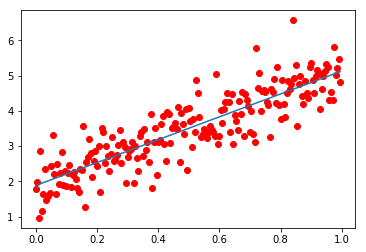

In [5]:
linear_fit =  lr.predict(X)
plt.plot(X,y,'ro')
plt.plot(X,linear_fit)
plt.show()

## 1. Hold-out method

The hold-out method is one of the most popular validation methods, due to its simplicity. The idea is to split the training data in two: one batch to train the model and the other to test it. In this way, we can formulate predictions and compare them with unseen data for which we have the responses. Since normally we count with limited amounts of data, we want to use the majority of it to train the model and a smaller fraction to test it. The percentage of data used for the split may vary, but 70%/30% is a standard choice. We will denote by $(X_{train},y_{train})$ and $(X_{test},y_{test})$ the two batches of data after the split. Note that for both of the batches we count with the response/output data.

Recall that in order to fit the linear regression model, we optimize the parameters so that the mean squared error (MSE) is minimal. This means that as we iterate in the algorithm, the MSE computed with the entire dataset and the parameters at that iteration of the algorithm. More precisely, we denote by $\theta^{(k)}$ the parameter vector of the regression after the $k$-th iteration of the algorithm and $\text{MSE}^{(k)}$ the mean squared error computed with $\theta^{(k)}$. Then we can write

$$
\text{Training error}^{(k)} = \dfrac{1}{2m_\text{train}} (X_{train}\theta^{(k)}-y_{train})^T(X_{train}\theta^{(k)}-y_{train}),
$$

where $m_\text{train}$ is the length of $X_\text{train}$. We can also describe the **test error** as we iterate the algorithm. More precisely, 

$$
\text{Test Error}^{(k)} = \dfrac{1}{2m_\text{train}} (X_{test}\theta^{(k)}-y_{test})^T(X_{test}\theta^{(k)}-y_{test}),
$$

where $m_\text{test}$ is the length of $X_\text{test}$. Once the algorithm finishes training, we will have a last value for both the training and the test error. The training error will be a measure of how well is the algorithm predicting the values of the training set, while the test error will be a measure of the predictive capabilities of the model. If the training error is low but the test error is high, then the model is likely to be over-fitting the training data (having high variance), and thus, the algorithm will likely perform poorly on unseen data. Let us implement this method:

In [6]:
# (X,y): dataset
# p: proportion of the training set that will be used for trainig, while 1-p is the proportion of training points
#that will be used to test the algorithm

def hold_out(X,y,p):
    #We stack the features and responses so they are shuffled with the same permutation
    W = np.hstack([X.reshape(-1,1),y.reshape(-1,1)])
    
    #Shuffling
    np.random.shuffle(W)
    
    #Splitting
    return W[0:int(len(W)*p),0] , W[0:int(len(W)*p),1] , W[int(len(W)*p):,0] , W[int(len(W)*p):,1]

Note that the data is shuffled before the splitting, in case the data has some underlying structure that might skew the predictions; the idea is that the training example form a representative sample of the distribution from which the data is taken.

In [7]:
X_train , y_train , X_test , y_test = hold_out(X,y,0.75)

Once we split the data into the two batches, we can train our model with the training batch:

In [8]:
lr_hold = linear_regression()
lr_hold.train(X_train,y_train,200,1)

Now we can compute the scores described above:

In [9]:
# Training error
lr_hold.get_score(X_train,y_train)

0.13874598798079432

In [10]:
# Test error
lr_hold.get_score(X_test,y_test)

0.15937054068216408

It is worth noticing that it is possible for the test error to be lower than the training error if the model generalizes well. We plot the training and test errors as a function of the iterations

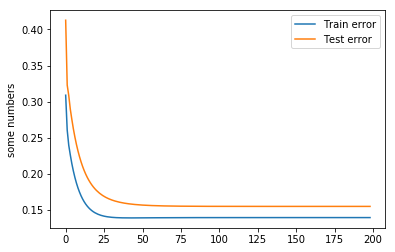

In [11]:
import matplotlib.pyplot as plt
plt.plot(lr.get_cost_history(X_train,y_train)[2:])
plt.plot(lr.get_cost_history(X_test,y_test)[2:])
plt.legend(['Train error','Test error'])
plt.ylabel('some numbers')
plt.show()


As long as both errors decrease, we know that the algorithm is converging to a local optimum.

## 2. K-folds method

One of the drawbacks of the hold-out method is that it is heavily dependent on the random shuffle performed before partitioning the dataset into the training and test batches. This means that its outcome has a high variance as a function of that partition. As a measure to decrease such variance, the K-folds method performs several computations of the test error for different partitions of the training data. 

More precisely, let $X=\{x_1,\dots,x_m \}$ , $y=\{y_1,\dots,y_m\}$ be the training data. We choose a random permutation of the indices $\sigma\in S_{m}$ and shuffle the dataset, obtaining a new array $X'=\{x_{\sigma(1)},\dots,x_{\sigma(m)} \} = \{x'_1,\dots,x'_m \}$, $y'=\{y_{\sigma(1)},\dots,y_{\sigma(m)}\}=(y'_1,\dots,y'_m)$. We divide the dataset in $K$ batches of size $s=m/K$: $X'_i=\{x'_{is+1},\dots,x'_{(i+1)s} \}$, $y'_i=\{y'_{is+1},\dots,y'_{(i+1)s} \}$ for $i=0,\dots,K-1$. Then, for each batch, we perform the hold-out method using such batch as the test data and the rest of the batches as the training data, splitting the data in $(X'_{\text{train},i},y'_{\text{train},i})=(X'_i,y'_i)$ and $(X'_{\text{test},i},y'_{\text{test},i})=(\bigcup_{k\neq i} X'_k,\bigcup_{k\neq i} y'_k)$. We obtain $K$ different training and test errors:

\begin{align*}
\text{Training error}_{i} &=  \dfrac{1}{2m_{\text{train},i}} (X'_{\text{train},i}\theta-y'_{\text{train},i})^T(X'_{\text{train},i}\theta-y'_{\text{train},i}),\\
\text{Test error}_{i} &=  \dfrac{1}{2m_{\text{test},i}} (X'_{\text{test},i}\theta-y'_{\text{test},i})^T(X'_{\text{test},i}\theta-y'_{\text{test},i}).
\end{align*}

Then we compute the averages of the training/test errors for all the batches

\begin{align*}
\text{Training error} &= \dfrac{1}{K}\displaystyle\sum_{i=1}^K \text{Training error}_{i}, \\
\text{Test error} &= \dfrac{1}{K}\displaystyle\sum_{i=1}^K \text{Test error}_{i} .
\end{align*}

In this way, we reduce the chances that due to a random biased splitting the training/test errors are not representative how the actual model is fitted or will predict for unseen data. We proceed to implement the algorithm:

In [12]:
def k_fold(X,y,k):
    #We stack the features and responses so they are shuffled with the same permutation
    W = np.hstack([X.reshape(-1,1),y.reshape(-1,1)])
    
    #Shuffling 
    np.random.shuffle(W)
    n = int(len(X)/k)
    
    training_cost = 0
    test_cost = 0
    
    #Fit the model and perform hold-out for each batch as a test dataset
    for i in range(k):
        #Defining the batches
        X_test = W[i*n:(i+1)*n,0]
        y_test = W[i*n:(i+1)*n,1]
        X_train = np.array([W[i,0] for i in range(len(X)) if i not in range(i*n,(i+1)*n)])
        y_train = np.array([W[i,1] for i in range(len(X)) if i not in range(i*n,(i+1)*n)])
        
        #Training the model and getting the costs
        model = linear_regression()
        model.train(X_train,y_train,200,1)
        training_cost += model.get_score(X_train,y_train)
        test_cost += model.get_score(X_test,y_test)
        
    #Report average cost
    return ("Training error = {} , test error = {}".format(training_cost/k,test_cost/k))

We can now run the algorithm and get the training and test scores:

In [13]:
k_fold(X,y,5)

'Training error = 0.14276893298899035 , test error = 0.143280932321153'

## 3. Stratified K-folds method

In the previous method, it is implicitly assumed that the dataset is balanced, this is, is we plot the histogram of the responses, it looks roughly uniform. This means that is very likely that the batches constructed using the K-folds method are representative of our dataset. If the dataset is not balanced and there are quantiles with many more points of data, then an option is to stratify the Folds. We will not go into the details of this method, as its implementation is slightly more delicate than the other methods of this notebook.

## 4. Leave-one-out method

This is the first exhaustive method we will study. The idea of this method is to train the model with all but one data points, and test the model using that particular data point not used during the training phase. We repeat this process going through all the data points of our dataset, and then report the average error. In this way, we go through all the possible splittings, so there is no randomness involved in the process, reducing in this way the variance of the outcome. 

More precisely, for every $i$, define the datasets $X_{\text{train},i}=\{x_1,\dots,x_{i-1},x_{i+1},\dots,x_m \}$ and $y_{\text{train},i}=\{y_1,\dots,y_{i-1},y_{i+1},\dots,y_m \}$ and the training and test errors

\begin{align*}
\text{Training error}_{i} &=  \dfrac{1}{m-1} (X_{\text{train},i}\theta-y_{\text{train},i})^T(X_{\text{train},i}\theta-y_{\text{train},i}),\\
\text{Test error}_{i} &=  \dfrac{1}{2}(\theta\cdot x_i - y_i)^2
\end{align*}

And then we average over all the indices

\begin{align*}
\text{Training error} &= \dfrac{1}{m}\sum_{i=1}^m\text{Training error}_{i} \\
\text{Test error} &= \dfrac{1}{m}\sum_{i=1}^m\text{Test error}_{i} 
\end{align*}

In [14]:
def leave_one_out(X,y):
    train_cost = 0
    test_cost = 0 
    for i in range(len(X)):
        #Define the training data
        X_train = np.array([X[k] for k in range(len(X)) if k != i])
        y_train = np.array([y[k] for k in range(len(y)) if k != i])
        
        #Train the model with the dataset
        model = linear_regression()
        model.train(X_train,y_train,200,1)
        
        #Compute the error of the point left out
        train_cost += model.get_score(X_train,y_train)
        test_cost += (1/2)*(model.predict(X[i]) - y[i])**2
    
    #Report the average cost
    return ("Training error: {} , Test error: {}".format(train_cost/len(X), test_cost/len(X)))

In [15]:
leave_one_out(X,y)

'Training error: 0.14325197192256525 , Test error: 0.14610191564816274'

## 5. Leave-p-out method

The leave-p-out method is a generalization of the previous method, in which instead of leaving one data point out of the training set, we leave p and use the rest of the points to train the model. We loop this algorithm over all the possible configurations leaving p points out of the training set. This is computationally much more expensive, since the number of possible configurations grows really fast when $n$ is large. We will not provide the details of this method, as it is much more involved than the other methods implemented in this notebook, and the idea is essentially the same as in the previous method.

## Final remarks

We finish this notebook by remarking that there is not an absolute best method of evaluation, as the model complexity plays a big role in the decision we face when deciding which method to use. We also remark that for hyperparameter tuning, an extra validation step is required, as we want to prevent data leakage, this is, using information of the test set in the training phase, making the evaluation scores unreliable. Finally, we remark that for classification problems, we will introduce in future notebooks, much more specialized scores to evaluate the performance of the algorithms.